In [1]:
import pickle
import numpy as np
import scvelo as scv
import scanpy
import torch

from veloproj import *

scv.settings.verbosity = 1

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-5',
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '50',
                               '--k-dim', '50',
                               '--data-dir', './oligo_lite.h5ad',
                               '--model-name', 'oligo_model.cpt',
                               '--exp-name', 'CohAE_oligo',
                               '--device', 'cuda:2',
                               '--gumbsoft_tau', '5',
                               '--nb_g_src', 'X',
                               '--ld_nb_g_src', "SU",
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '100',
                               '--fit_offset_train', 'false',
                               '--fit_offset_pred', 'true',
                               '--use_offset_pred', 'false',
                               '--gnn_layer', 'GAT',
                               '--vis-key', 'X_umap',
                               '--vis_type_col', 'celltype',
                               '--scv_n_jobs', '10',
                               '--mask_cluster_list', 'velo_constraint_cluster_list.txt', # in comparison with the retina dataset adding velocity constrints to
                                                                                          # low-dimentional space for all the cells, 
                                                                                          # we provide an interface for users to specify specific cell clusters
                                                                                          # which we would like to constrain
                                                                                          # this argument specifes the path to a file with the first row indicating
                                                                                          # the cluster column name in adata.obs DataFrame
                                                                                          # and the rest rows denote the cluster types for constrain.
                                                                                          # in this example, we constrain the velocity of `NFOLs`
                                                                                          # to be similar between projected and linear regression estimated low-dimensional space,
                                                                                          # doing some type of `transfer learning` from scvelo stochastic mode to veloAE
                               '--v_rg_wt', '500',
                               '--sl1_beta', '8'
                              ])
args                              

Namespace(adata=None, aux_weight=100.0, conv_thred=1e-06, data_dir='./oligo_lite.h5ad', device='cuda:2', exp_name='CohAE_oligo', fit_offset_pred=True, fit_offset_train=False, g_rep_dim=50, gnn_layer='GAT', gumbsoft_tau=5.0, h_dim=256, is_half=False, k_dim=50, ld_adata='projection.h5', ld_nb_g_src='SU', log_interval=100, lr=1e-05, lr_decay=0.9, mask_cluster_list='velo_constraint_cluster_list.txt', model_name='oligo_model.cpt', n_conn_nb=30, n_epochs=20000, n_nb_newadata=30, n_raw_gene=2000, nb_g_src='X', output='./', refit=True, scv_n_jobs=10, seed=42, sl1_beta=8.0, use_norm=False, use_offset_pred=False, use_x=False, v_rg_wt=500.0, vis_key='X_umap', vis_type_col='celltype', weight_decay=0.0, z_dim=100)

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [
    ("COPs", "NFOLs"), 
    ("NFOLs", "MFOLs")]
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [6]:
adata = scanpy.read_h5ad(args.data_dir)
scv.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.64 0.36]
AnnData object with n_obs × n_vars = 6253 × 2000
    obs: 'Age', 'Cell_Conc', 'ChipID', 'Clusters', 'Comments', 'Date_Captured', 'DonorID', 'Label', 'NGI_PlateWell', 'Num_Pooled_Animals', 'PCR_Cycles', 'Plug_Date', 'Project', 'SampleID', 'SampleOK', 'Sample_Index', 'Seq_Comment', 'Seq_Lib_Date', 'Seq_Lib_Ok', 'Serial_Number', 'Sex', 'Species', 'Strain', 'Target_Num_Cells', 'Tissue', 'Transcriptome', '_X', '_Y', 'cDNA_Lib_Ok', 'ngperul_cDNA', 'V1', 'V2', 'label', 'celltype', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors'
    obsm: 'X_coor', 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


  0%|          | 0/6253 [00:00<?, ?cells/s]

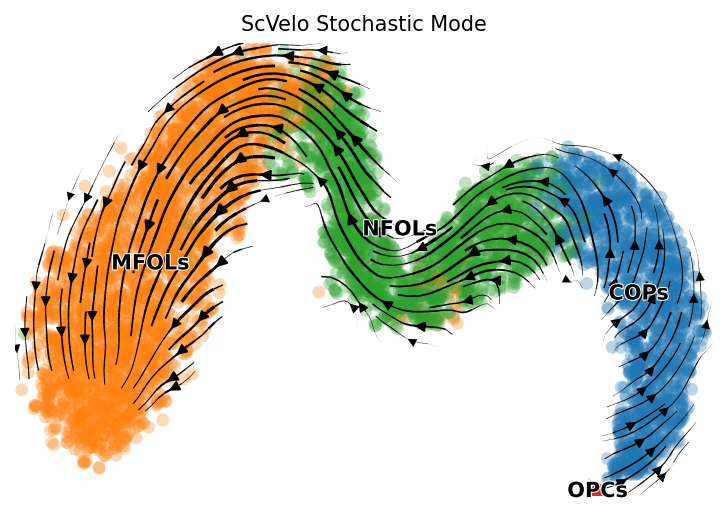

# Cross-Boundary Transition Score (A->B)
{('COPs', 'NFOLs'): 0.13601112, ('NFOLs', 'MFOLs'): 0.2676039}
Total Mean: 0.20180751383304596
# Cross-Boundary Velocity Coherence (A->B)
{('COPs', 'NFOLs'): 0.86201894, ('NFOLs', 'MFOLs'): 0.8960272}
Total Mean: 0.8790230751037598
# Cross-Boundary Direction Correctness (A->B)
{('COPs', 'NFOLs'): 0.18456332196112613, ('NFOLs', 'MFOLs'): 0.527163266529319}
Total Mean: 0.35586329424522256
# In-cluster Coherence
{'COPs': 0.89906085, 'MFOLs': 0.9619137, 'NFOLs': 0.9057924, 'OPCs': 0.8825826}
Total Mean: 0.9123374223709106
# In-cluster Confidence
{'COPs': 0.8975995237356137, 'MFOLs': 0.9524482225827059, 'NFOLs': 0.8943025764184453, 'OPCs': 0.8614016425225043}
Total Mean: 0.9014379913148174


In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata,  vkey="stc_velocity", basis=args.vis_key, color=args.vis_type_col,
                                 dpi=150, 
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, args.vis_type_col, "stc_velocity")

Loss: (Total) 78.359283, (AE) 77.568756, (LR) 100.00 * 0.000732, (RG) 500.00 * 0.001435: 100%|██████████| 20000/20000 [23:42<00:00, 14.06it/s]  


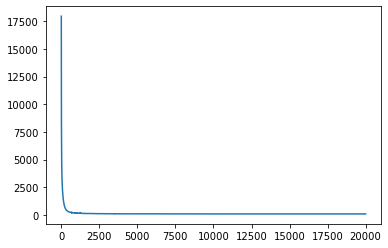

In [8]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

  0%|          | 0/6253 [00:00<?, ?cells/s]

saving figure to file ./figures/scvelo_oligodendrocyte_pojection.png


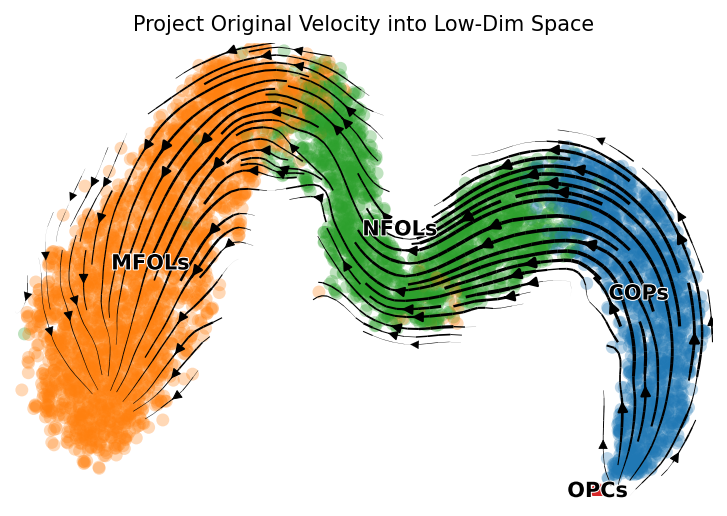

# Cross-Boundary Transition Score (A->B)
{('COPs', 'NFOLs'): 0.2392812, ('NFOLs', 'MFOLs'): 0.104577646}
Total Mean: 0.17192941904067993
# Cross-Boundary Velocity Coherence (A->B)
{('COPs', 'NFOLs'): 0.9953603, ('NFOLs', 'MFOLs'): 0.996584}
Total Mean: 0.9959721565246582
# Cross-Boundary Direction Correctness (A->B)
{('COPs', 'NFOLs'): 0.8487240633966037, ('NFOLs', 'MFOLs'): 0.5442262991169514}
Total Mean: 0.6964751812567775
# In-cluster Coherence
{'COPs': 0.9963123, 'MFOLs': 0.99721044, 'NFOLs': 0.99829817, 'OPCs': 0.99997526}
Total Mean: 0.9979490041732788
# In-cluster Confidence
{'COPs': 0.996084103778113, 'MFOLs': 0.9970275277809268, 'NFOLs': 0.9978537890824896, 'OPCs': 0.9856352421545214}
Total Mean: 0.9941501656990126


In [9]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                 use_offset=args.use_offset_pred).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.ld_nb_g_src, n_nb_newadata=args.n_nb_newadata)
    scv.tl.velocity_graph(adata, vkey='new_velocity', n_jobs=args.scv_n_jobs)
    scv.pl.velocity_embedding_stream(adata,  vkey="new_velocity", basis=args.vis_key, color=args.vis_type_col,
                                    title="Project Original Velocity into Low-Dim Space",
                                    dpi=150,
                                    save='oligodendrocyte_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, args.vis_type_col, "new_velocity")
    
exp(adata, exp_metrics)

Abundance of ['spliced', 'unspliced']: [0.64 0.36]


  0%|          | 0/757 [00:00<?, ?gene/s]

  0%|          | 0/6253 [00:00<?, ?cells/s]

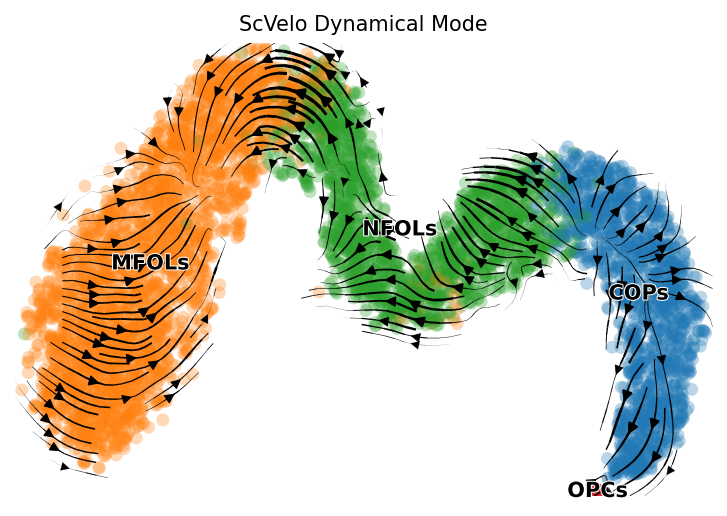

# Cross-Boundary Transition Score (A->B)
{('COPs', 'NFOLs'): 0.39235646, ('NFOLs', 'MFOLs'): 0.43137965}
Total Mean: 0.41186803579330444
# Cross-Boundary Velocity Coherence (A->B)
{('COPs', 'NFOLs'): 0.8339525880108608, ('NFOLs', 'MFOLs'): 0.7648149955134319}
Total Mean: 0.7993837917621464
# Cross-Boundary Direction Correctness (A->B)
{('COPs', 'NFOLs'): -0.045721793801200644, ('NFOLs', 'MFOLs'): 0.09865751437961526}
Total Mean: 0.026467860289207307
# In-cluster Coherence
{'COPs': 0.9741825131895359, 'MFOLs': 0.8120565060783369, 'NFOLs': 0.7916376122571769, 'OPCs': 0.9990290240941994}
Total Mean: 0.8942264139048123
# In-cluster Confidence
{'COPs': 0.9734623313499147, 'MFOLs': 0.8024698073010618, 'NFOLs': 0.7887305956486915, 'OPCs': 0.9938755845841556}
Total Mean: 0.8896345797209559


In [10]:
adata = scanpy.read_h5ad(args.data_dir)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(adata, n_jobs=args.scv_n_jobs)
scv.tl.velocity(adata, vkey='dyn_velocity', mode="dynamical")

scv.tl.velocity_graph(adata, vkey='dyn_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='dyn_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                vkey="dyn_velocity", 
                                basis=args.vis_key, 
                                color=[args.vis_type_col],
                                dpi=150, 
                                title='ScVelo Dynamical Mode')
exp_metrics["dyn_mode"] = evaluate(adata[:, adata.var.dyn_velocity_genes], cluster_edges, args.vis_type_col, "dyn_velocity")

In [11]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)